In [1]:
%load_ext autoreload
%autoreload 2

import sys
import warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

sys.path.append('../..')
warnings.filterwarnings('ignore')

from batchflow import NumpySampler, ConstantSampler
from batchflow.models.tf import DeepGalerkin, DGSolver, TFModel
from batchflow.sampler import cart_prod
from batchflow.models.tf.layers import conv_block

In [2]:
class ModifiedDG(DeepGalerkin):  
    
    @classmethod
    def body(cls, inputs, name='body', **kwargs):
        return cls.gated_unit(inputs, name='body-gu')
    
    @classmethod
    def gated_unit(cls, inputs, name='gated_unit', size=3, width=50, activation=tf.nn.tanh, **kwargs):
        x = inputs
        
        with tf.variable_scope(name):
            s_0 = conv_block(x, layout='fa', units=width, activation=activation, name='s_0')
            s = s_0

            for i in range(size):
                with tf.variable_scope('loop-{}'.format(i)):
                    z = activation(tf.layers.dense(x, units=width, name='z_1')
                                   + tf.layers.dense(s, units=width, name='z_2'))

                    g = activation(tf.layers.dense(x, units=width, name='g_1')
                                   + tf.layers.dense(s_0, units=width, name='g_2'))

                    r = activation(tf.layers.dense(x, units=width, name='r_1')
                                   + tf.layers.dense(s, units=width, name='r_2'))

                    xsr = tf.concat([x, tf.multiply(s, r)], axis=-1)
    
                    h = activation(tf.layers.dense(x, units=width, name='h_1')
                                   + tf.layers.dense(tf.multiply(s, r), units=width, name='h_2'))

                    s = tf.multiply((tf.ones(shape=(tf.shape(g))) - g), h) + tf.multiply(z, s)   
            output = tf.layers.dense(s, units=1, name='dense')
            output = tf.identity(output, name='output')
        return output

# Simple equation, no need to change RHS whatsoever:

$$
u'(t) - u(t) = k \cos(kt) e^t, \\
u(0) = 0
$$

In [10]:
# describing pde-problem in pde-dict
K = 5

pde = {'form': {'d0': -1,
                'd1': (1, )},
       'rhs': lambda t: K*tf.cos(K*t) * tf.exp(t),
       'time_multiplier': 'polynomial',
       'initial_condition': 0,
       'bind_bc_ic': True}   


# put it together in model-config
config = {'pde': pde,
          'loss': 'mse',
         }

# uniform sampling scheme
s = NumpySampler('uniform')


In [14]:
dg = DGSolver(config, dg_class=ModifiedDG)
# equation condition addendum
dg.fit(sampler=s, batch_size=200, n_iters=500, fetches='loss', bar='notebook')

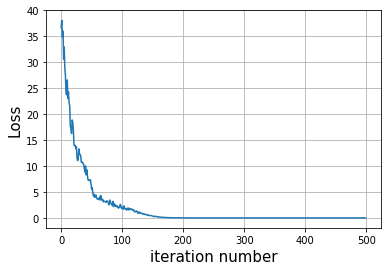

In [15]:
# plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.grid(True)
plt.show()

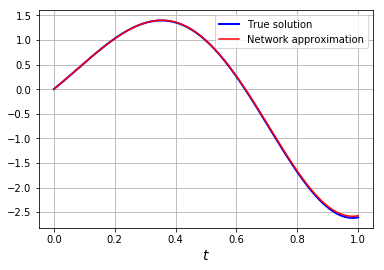

In [16]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

sol = lambda t: np.sin(K*t)*np.exp(t) + 0
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b', linewidth=2, label='True solution')

approxs = dg.solve(pts)
plt.plot(pts, approxs, 'r', label='Network approximation')

plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()

# Got additional information: 
$$
u(0.5) = 2
$$

In [34]:
# describing pde-problem in pde-dict
K = 5

block = {'layout': 'fa Rfa fa. fa f',
         'units': [15]*4 + [1],
         'activation': tf.nn.tanh}

pde = {'form': {'d0': -1,
                'd1': (1, )},
#        'form_noise': {'d0': 0.001,},
       'form_add': {'rhs': 1},
       'addendum_block': block,
       'rhs': lambda t: K*tf.cos(K*t) * tf.exp(t),
       'additional_rhs': {'cond_1': lambda t: 2*tf.ones(shape=tf.shape(t))},
       'time_multiplier': 'polynomial',
       'initial_condition': 0,
       'bind_bc_ic': True}   


# put it together in model-config
config = {'pde': pde,
          'loss': 'mse',
          'decay': {'name': 'invtime', 'learning_rate':0.001, 'decay_steps': 100, 'decay_rate': 0.05},
          'train_steps': {'adds': {'scope': 'addendums'},
                          'cond_1': {'scope': '-addendums', 
                                     'loss':{'name': 'mse', 'predictions':'solution', 'targets':'cond_1'}},
                          'rest': {'scope': '-addendums',}
                         },
         }

# uniform sampling scheme
s = NumpySampler('uniform')
s_cond_1 = ConstantSampler(0.5)

In [42]:
dg = DGSolver(config, dg_class=ModifiedDG)
# equation condition addendum
iters = [4, 4, 4]

for _ in tqdm_notebook(range(100)):
    _ = dg.fit(sampler=s, batch_size=1000, n_iters=iters[0], fetches='loss_rest', train_mode='rest')
    
    _ = dg.fit(sampler=s_cond_1, batch_size=1000, n_iters=iters[1], fetches='loss_cond_1', train_mode='cond_1')
    _ = dg.fit(sampler=s, batch_size=1000, n_iters=iters[2], fetches='loss_adds', train_mode='adds')
    

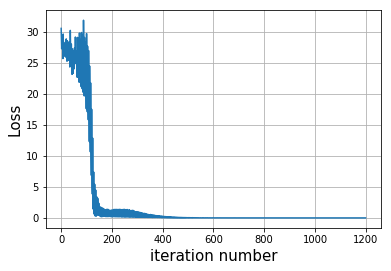

In [43]:
# plot loss
plt.plot(dg.loss_rest[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.grid(True)
plt.show()

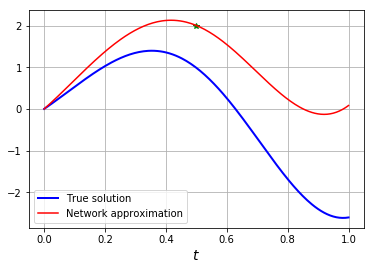

In [44]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

sol = lambda t: np.sin(K*t)*np.exp(t) + 0
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b', linewidth=2, label='True solution')

plt.plot([0.5], [2], '*g', linewidth=8)

approxs = dg.solve(pts)
plt.plot(pts, approxs, 'r', label='Network approximation')

plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()

In [45]:
dg.solve([[0.5]])

array([[2.002864]], dtype=float32)

# Shift solution to approximate something else:
Entire solution after $t\in[0.4, 0.7]$ is shifted $2$ units up

Entire solution after $t\in[0.7, 1.0]$ is shifted $3$ units up

In [3]:
# describing pde-problem in pde-dict
K = 5

block = {'layout': 'fa Rfa fa. fa f',
         'units': [15]*4 + [1],
         'activation': tf.nn.tanh}

pde = {'form': {'d0': -1,
                'd1': (1, )},
#        'form_noise': {'d0': 0.001,},
       'form_add': {'rhs': {'units': [50]*4 + [1]},
                    'd0': 1,
                    'd1': (1)},
       'addendum_block': block,
       'rhs': lambda t: K*tf.cos(K*t) * tf.exp(t),
       'additional_lhs': {'equation_alias': {'form': {'d0': 1}}},
       'additional_rhs': {'cond_1': lambda t: tf.sin(K*t)*tf.exp(t)+2,
                          'cond_2': lambda t: tf.sin(K*t)*tf.exp(t)+3},
       'time_multiplier': 'polynomial',
       'initial_condition': 0,
       'bind_bc_ic': True}   


# put it together in model-config
config = {'pde': pde,
          'loss': 'mse',
          'decay': {'name': 'invtime', 'learning_rate':0.001, 'decay_steps': 100, 'decay_rate': 0.05},
          'train_steps': {'adds': {'scope': 'addendums'},
                          'cond_1': {'scope': '-addendums', 
                                     'loss':{'name': 'mse', 'predictions':'equation_alias', 'targets':'cond_1'}},
                          'cond_2': {'scope': '-addendums',
                                     'loss':{'name': 'mse', 'predictions':'solution', 'targets':'cond_2'}},
                          'rest': {'scope': '-addendums',}
                         },
         }

# uniform sampling scheme
s = NumpySampler('uniform')
s_cond_1 = NumpySampler('uniform', low=0.4, high=0.7)# ConstantSampler(0.5) # 
s_cond_2 = NumpySampler('uniform', low=0.75, high=0.99)

In [4]:
dg = DGSolver(config, dg_class=ModifiedDG)
# equation condition addendum
iters = [4, 2, 4, 4, 2, 4]

for _ in tqdm_notebook(range(1000)):
    _ = dg.fit(sampler=s, batch_size=1000, n_iters=iters[0], fetches='loss_rest', train_mode='rest')
    
    _ = dg.fit(sampler=s_cond_1, batch_size=1000, n_iters=iters[1], fetches='loss_cond_1', train_mode='cond_1')
    _ = dg.fit(sampler=s, batch_size=1000, n_iters=iters[2], fetches='loss_adds', train_mode='adds')
    
    _ = dg.fit(sampler=s, batch_size=1000, n_iters=iters[3], fetches='loss_rest', train_mode='rest')
    
    _ = dg.fit(sampler=s_cond_2, batch_size=1000, n_iters=iters[4], fetches='loss_cond_2', train_mode='cond_2')
    _ = dg.fit(sampler=s, batch_size=1000, n_iters=iters[5], fetches='loss_adds', train_mode='adds')



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


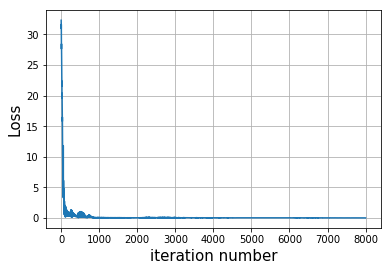

In [5]:
# plot loss
plt.plot(dg.loss_rest[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.grid(True)
plt.show()

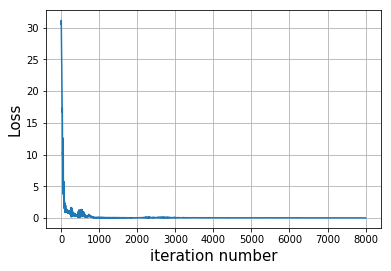

In [6]:
# plot loss
plt.plot(dg.loss_adds[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.grid(True)
plt.show()

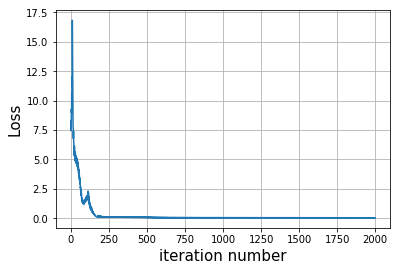

In [7]:
# plot loss
plt.plot(dg.loss_cond_1[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.grid(True)
plt.show()

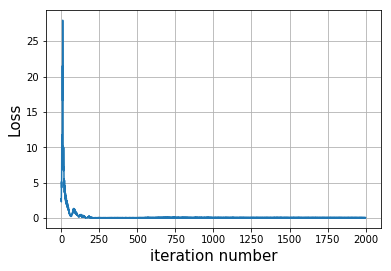

In [8]:
# plot loss
plt.plot(dg.loss_cond_2[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.grid(True)
plt.show()

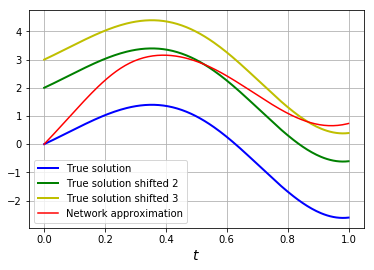

In [9]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

sol = lambda t: np.sin(K*t)*np.exp(t) + 0
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b', linewidth=2, label='True solution')

shifted = [sol(t[0])+2 for t in pts]
plt.plot(pts, shifted, 'g', linewidth=2, label='True solution shifted 2')

shifted_ = [sol(t[0])+3 for t in pts]
plt.plot(pts, shifted_, 'y', linewidth=2, label='True solution shifted 3')

approxs = dg.solve(pts)
plt.plot(pts, approxs, 'r', label='Network approximation')

plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()